## Libraries and data Loading

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from multivariateGCI_mr import MultivariateGCI_mr
from multivariateGCI_sr import MultivariateGCI_sr

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, IBMQ, transpile, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem, AmplitudeEstimation
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import LinearAmplitudeFunction, QFT

In [15]:
df = pd.read_csv("Data/sampled_counterparts.csv")
# df = df[((df['pd']>=0.1) & ((1000 < df['lgd dwt']*df['ead']) & (df['lgd dwt']*df['ead'] < 5000000)))]
df =  df.iloc[[38-2, 260-2]] #df.iloc[[38-2, 260-2, 7816-2]] 

F_matrix = pd.read_csv("Data/F_for_sampled_counterparts.csv")
sectors = [1] #[1, 2]
F_values = [[F_matrix.iloc[df.index.values[j]][i-1] for i in sectors] for j in range(len(df))]
# F_values = [[0.55], [0.65], [0.50]] # make F/rhos

## Parameters setting

In [16]:
# set problem parameters
n_z = 2
z_max = 2

p_zeros = [el['pd'] for _, el in df.iterrows()]
rhos = [el['is']**2 for _, el in df.iterrows()]
lgd = [el['lgd dwt']*el['ead'] for _, el in df.iterrows()]

K = len(p_zeros)

alpha_var = 0.05

print(f'F: {F_values}\nRhos: {np.sqrt(rhos)}\nLgds: {lgd}\np_zeros: {p_zeros}')
df

F: [[0.1580707722], [0.2555327991]]
Rhos: [0.3 0.3]
Lgds: [18406.56224845756, 54807.94141703075]
p_zeros: [0.2565108504, 0.0715568886]


,cluster,pd,lgd dwt,ead,num ctp,sett,is,acca,cod type,cod stato,lgd pag
36,005118_618,0.256511,0.223071,82514.537908,83292,5,0.3,0.000083,0,0,0.187699
258,002116_18,0.071557,0.194311,282063.242107,888,2,0.3,0.019318,0,0,0.157672


### Encoding of the uncertainty model

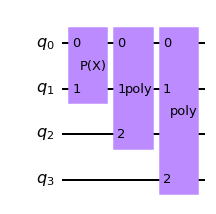

In [17]:
u = MultivariateGCI_sr(n_z, z_max, p_zeros, rhos, F_values[1])
u = MultivariateGCI_mr(n_z, z_max, p_zeros, rhos, F_values)

# from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

# u = GCI(n_z, z_max, p_zeros, rhos)

# print(u.decompose().draw(output='latex_source'))
u.decompose().draw("mpl")

## Uncertainty model testing

In [18]:
# run the circuit and analyze the results
job = execute(u, backend=Aer.get_backend('statevector_simulator'),) # n_shots=n_shots)

# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
for i, a in enumerate(np.array(job.result().get_statevector())):
    
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2
    
    # extract value of Z and corresponding probability    
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha_var)
exact_var = losses[i_var]

print('Expected Loss E[L]:                %.4f' % expected_loss)
print('Value at Risk VaR[L]:              %.4f' % exact_var)

# # plot loss CDF
# plt.rcParams['text.usetex'] = True
# plt.rcParams["figure.figsize"] = (8, 8)
# plt.plot(np.sort(np.unique(losses)), cdf, 'o-g')
# plt.axhline(1-alpha_var, color="orange", linestyle="--")
   
# plt.xlabel("Loss L ($)", size=17)
# plt.ylabel(r'$P[\mathcal{L} \leq X]$', size=17) 
# plt.title ("CDF of Total Loss", size=17)
# plt.xticks(size=17) # plt.xticks(np.sort(np.unique(losses)), np.sort(np.unique(losses)), size=17)
# plt.yticks(size=17)
# plt.show()
# cdf

Expected Loss E[L]:                8243.3829
Value at Risk VaR[L]:              54807.9414


In [19]:
def mapping(decimal_number):
    b = ('{0:0%sb}' % K).format(decimal_number)
    #print(b)
    losses = [loss for i, loss in enumerate(lgd[::-1]) if b[i]=='1']
    #print(losses)
    total_loss = sum(losses)
    return total_loss

def find_breakpoint(x_eval):
    for el in range(0,2**K):
        if mapping(el) <= x_eval:
            if mapping(el+1) >= x_eval:
                return el
    return 0

depth = 'e_loss'

In [20]:
if depth == 'e_loss':
    # define linear objective function for expected loss
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    offsets = [mapping(el) for el in breakpoints]
    f_min = 0
    f_max = sum(lgd)
    c_approx = 0.01

    objective_e_loss = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

In [21]:
# from qiskit.circuit.library import WeightedAdder

# agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

# # define linear objective function
# breakpoints = [0]
# slopes = [1]
# offsets = [0]
# f_min = 0
# f_max = sum(lgd)
# c_approx = 0.25

# objective_loss = LinearAmplitudeFunction(
#     agg.num_sum_qubits,
#     slope=slopes,
#     offset=offsets,
#     # max value that can be reached by the qubit register (will not always be reached)
#     domain=(0, 2 ** agg.num_sum_qubits - 1),
#     image=(f_min, f_max),
#     rescaling_factor=c_approx,
#     breakpoints=breakpoints,
# )

## Testing without QAE

In [22]:
from qiskit.circuit.library import LinearAmplitudeFunction


def get_cdf_circuit(x_eval):
    
    # define linear objective function for cdf
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    # print(values)
    offsets = [1 if mapping(el)<=x_eval else 0 for el in breakpoints]
    f_min = 0
    f_max = 1
    c_approx = 0.01
    
    objective = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, name='A')

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)

    # linear objective function (does aggregation and comparison)
    if depth == 'e_loss':
        state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective_e_loss
    else:
        state_preparation.append(objective.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective
    
example = 0
state_preparation, objective = get_cdf_circuit(example)
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

# evaluate resulting statevector
var_prob = 0
for i, a in enumerate(np.array(job.result().get_statevector())):
    b = ('{0:0%sb}' % (u.num_qubits + 1)).format(i)[-(u.num_qubits + 1):]
    prob = np.abs(a)**2
    if b[0] == '1':
        var_prob += prob
if depth == 'e_loss':
    print('Operator Expected Loss' + ' = %.4f' % objective.post_processing(var_prob), var_prob)
else:
    print('Operator CDF(%s)' % example + ' = %.4f' % objective.post_processing(var_prob))
state_preparation.draw()
# objective.decompose().decompose().draw()

Operator Expected Loss = 8244.4468 0.49391484094411564


┌───────┐      
  state_0: ┤0      ├──────
           │       │      
  state_1: ┤1      ├──────
           │  P(X) │┌────┐
  state_2: ┤2      ├┤0   ├
           │       ││    │
  state_3: ┤3      ├┤1   ├
           └───────┘│    │
objective: ─────────┤2 F ├
                    │    │
   work_0: ─────────┤3   ├
                    │    │
   work_1: ─────────┤4   ├
                    └────┘

## Experiments
### Setup

In [23]:
import time
# set target precision and confidence level
epsilon = 0.01/6
alpha = 0.05/6

simulated = True
optimization_level = 1
n_shots = 2048

# get backend
backend_name = ''
# try:
#     provider = IBMQ.get_provider(hub='ibm-q-research-2', group='politecnico-tor-1', project='main')
# except:
#     IBMQ.load_account()
#     provider = IBMQ.get_provider(hub='ibm-q-research-2', group='politecnico-tor-1', project='main')
    
# backend = provider.get_backend(backend_name)

qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)

# if simulated == False:
#     qi_noise = QuantumInstance(backend, shots=n_shots, 
#                             optimization_level=optimization_level, seed_transpiler=42)
                            
# else:
#     noise_model = NoiseModel.from_backend(backend)
#     # Get coupling map from backend
#     coupling_map = backend.configuration().coupling_map
#     # Get basis gates from noise model
#     basis_gates = noise_model.basis_gates
from qiskit.test.mock import FakeMontreal

qi_noise = QuantumInstance(FakeMontreal(), shots=n_shots, 
                        optimization_level=optimization_level, seed_transpiler=42)

### Running

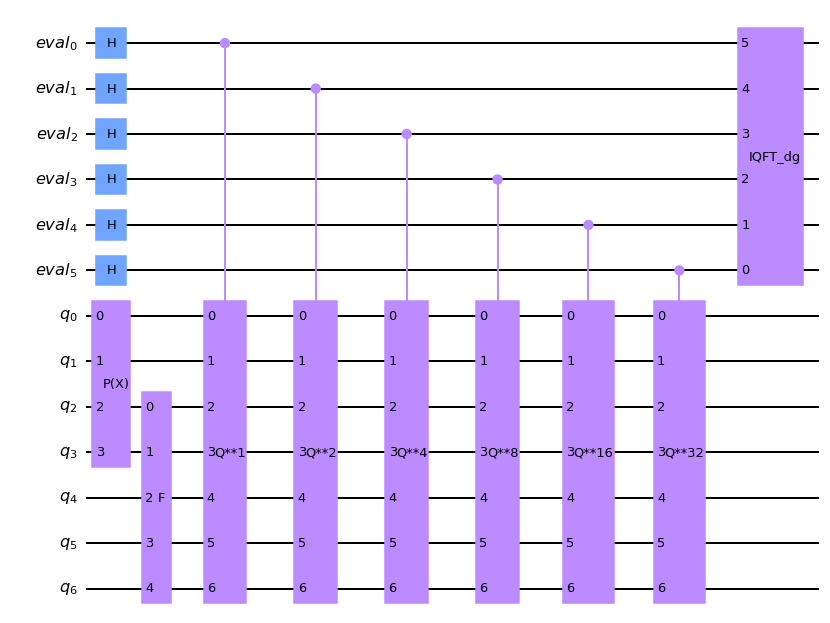

In [24]:
qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=10000, 
                           optimization_level=optimization_level, seed_transpiler=42)
problem = EstimationProblem(state_preparation=state_preparation,
                            objective_qubits=[u.num_qubits],
                            post_processing=objective.post_processing)

ae_sequential = AmplitudeEstimation(6, quantum_instance=qi_ideal)
circuit = ae_sequential.construct_circuit(problem)

# ideal_result = ae_sequential.estimate(problem)
# print("result with no noise:", ideal_result.mle_processed, ideal_result.mle)
circuit.decompose().draw("mpl", filename='Images/canonical_ae_k_63.svg')

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_algiers")

In [33]:
from qiskit.test.mock import FakeMontreal
if depth == 'e_loss':
    #from qiskit.visualization import plot_circuit_layout

    tr_ae_circuit = transpile(circuit, optimization_level=optimization_level, backend=backend, seed_transpiler=42)
    
    # Return circuit depth (i.e., length of critical path).
    print(tr_ae_circuit.depth()) #883039 montreal - 901717 algiers (832217 with opt_level=2) - 880994 canberra (843007 with opt_level=2)
    # Returns total number of instructions in circuit.
    print(tr_ae_circuit.size()) #1186068 montreal - 1198662 algiers (1086111 with opt_level=2) - 1182081 canberra (1106202 with opt_level=2)

    #plot_circuit_layout(tr_ae_circuit, backend)

843007
1106202


In [ ]:
grover_op2 = problem.grover_operator #GroverOperator(oracle2, state_preparation)
grover_op2.decompose().draw()

global phase: π
                                 ┌──────────┐┌───┐     ┌───┐┌───────┐      
state_0: ────────────────────────┤0         ├┤ X ├──■──┤ X ├┤0      ├──────
                                 │          │├───┤  │  ├───┤│       │      
state_1: ────────────────────────┤1         ├┤ X ├──■──┤ X ├┤1      ├──────
                        ┌───────┐│  P(X)_dg │├───┤  │  ├───┤│  P(X) │┌────┐
state_2: ───────────────┤0      ├┤2         ├┤ X ├──■──┤ X ├┤2      ├┤0   ├
                        │       ││          │├───┤  │  ├───┤│       ││    │
state_3: ───────────────┤1      ├┤3         ├┤ X ├──■──┤ X ├┤3      ├┤1   ├
         ┌───┐┌───┐┌───┐│       │└──┬───┬───┘└───┘  │  ├───┤└───────┘│    │
state_4: ┤ H ├┤ X ├┤ H ├┤2 F_dg ├───┤ X ├───────────■──┤ X ├─────────┤2 F ├
         └───┘└───┘└───┘│       │   ├───┤           │  ├───┤         │    │
state_5: ───────────────┤3      ├───┤ X ├───────────■──┤ X ├─────────┤3   ├
                        │       │   ├───┤    ┌───┐┌─┴─┐├───┤  ┌───┐  │    │
state_6: ───────────────┤4      ├───┤ X ├────┤ H ├┤ X ├┤ H ├──┤ X ├──┤4   ├
                        └───────┘   └───┘    └───┘└───┘└───┘  └───┘  └────┘

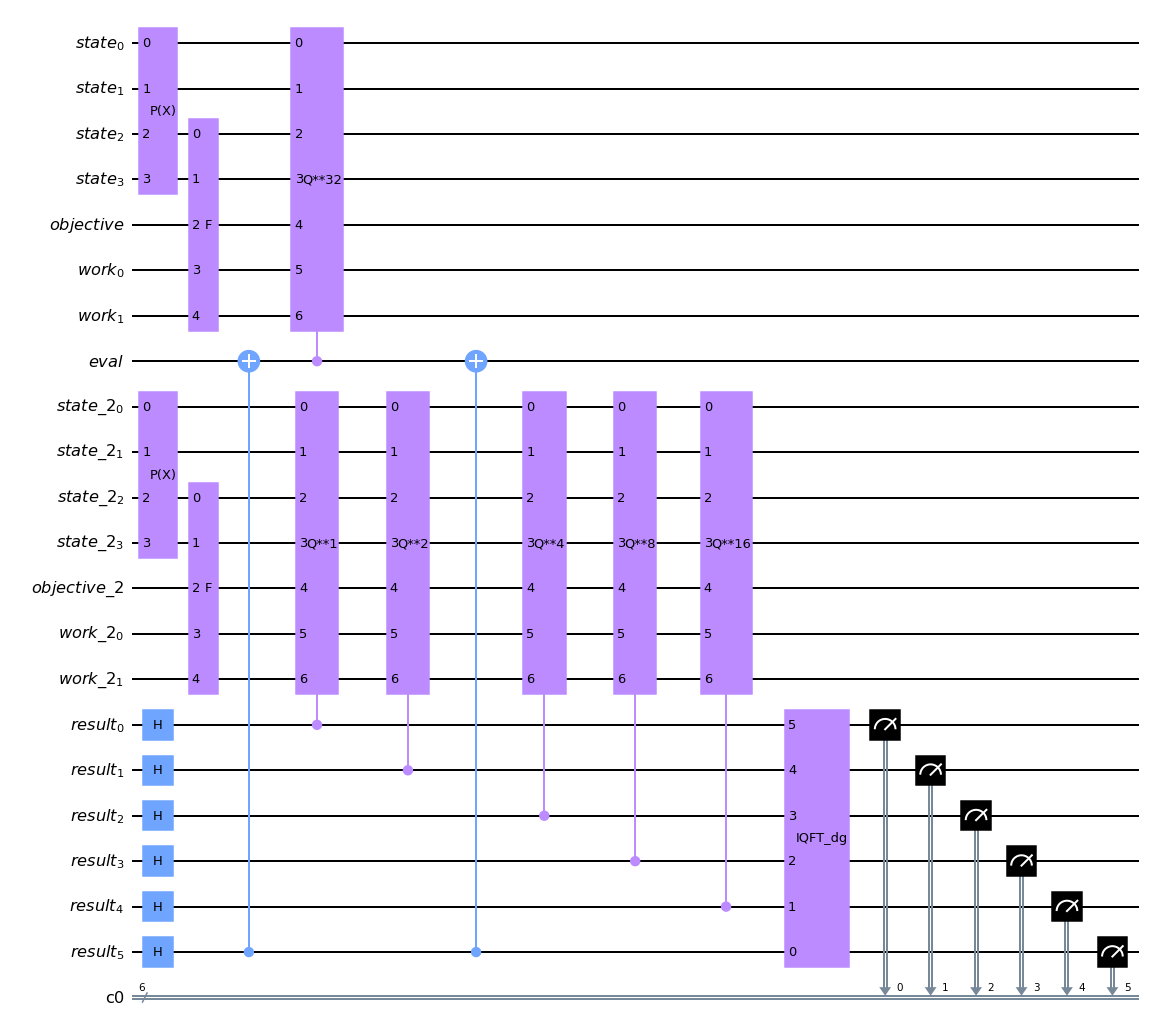

In [ ]:
resolution = 6
iqft = QFT(resolution, inverse=True, do_swaps=False).reverse_bits()
def get_parallelized_circuit():
    
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    qr_state2 = QuantumRegister(u.num_qubits, 'state_2')
    qr_obj2 = QuantumRegister(1, 'objective_2')
    ar2 = QuantumRegister(objective.num_ancillas, "work_2")  # additional qubits

    qr_result = QuantumRegister(resolution, 'result')
    qr_eval = QuantumRegister(1, 'eval')

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, qr_eval, qr_state2, qr_obj2, ar2, qr_result, name='A')

    for i in range(resolution):
        state_preparation.h(qr_result[i]) # hadamards on evaluation qubits
    # state_preparation.h(qr_result[1])

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)
    state_preparation.append(u.to_gate(), qr_state2)

    # state_preparation.cx(qr_result[0], qr_eval[0])



    # linear objective function (does aggregation and comparison)
    state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
    state_preparation.append(objective_e_loss.to_gate(), qr_state2[-K:] + qr_obj2[:] + ar2[:])
    state_preparation.cx(qr_result[resolution-1], qr_eval[0])
    # state_preparation.append(problem.grover_operator.to_gate(), qr_state[:] + qr_obj[:] + ar[:])
    
    state_preparation.compose(grover_op2.power(2**(resolution-1)).control(), qubits=qr_eval[:]+qr_state[:] + qr_obj[:] + ar[:], inplace=True)
    
    state_preparation.compose(grover_op2.power(2**0).control(), qubits=qr_result[:1]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.compose(grover_op2.power(2**1).control(), qubits=qr_result[1:2]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.compose(grover_op2.power(2**2).control(), qubits=qr_result[2:3]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.compose(grover_op2.power(2**3).control(), qubits=qr_result[3:4]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.compose(grover_op2.power(2**4).control(), qubits=qr_result[4:5]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.cx(qr_result[resolution-1], qr_eval[0])
    state_preparation.compose(iqft, qubits=qr_result[:], inplace=True)
    
    # state_preparation.append(qpe.to_gate(), qr_eval[:] + qr_state2[:] + qr_obj2[:] + ar2[:])
    # state_preparation.cx(qr_result[0], qr_result[0])
    cr = ClassicalRegister(resolution)
    state_preparation.add_register(cr)
    state_preparation.measure(qr_result[:], list(range(resolution)))

    return state_preparation, objective_e_loss

    
state_preparation2, objective = get_parallelized_circuit()
state_preparation2.draw("mpl", filename='Images/parallel_qae_k_63.svg')


In [ ]:
from collections import OrderedDict
from qiskit.algorithms.amplitude_estimators.ae_utils import pdf_a, bisect_max

def evaluate_count_results(counts):
    # construct probabilities
    measurements = OrderedDict()
    samples = OrderedDict()
    shots = n_shots

    for state, count in counts.items():
        y = int(state.replace(" ", "")[:resolution][::-1], 2)
        probability = count / shots
        measurements[y] = probability
        a = np.round(np.power(np.sin(y * np.pi / 2**resolution), 2), decimals=7)
        samples[a] = samples.get(a, 0.0) + probability

    return samples, measurements


def compute_mle(
        estimation, samples, apply_post_processing: bool = False
    ) -> float:

        m = resolution
        M = 2**m  # pylint: disable=invalid-name
        qae = estimation

        # likelihood function
        a_i = np.asarray(list(samples.keys()))
        p_i = np.asarray(list(samples.values()))

        def loglikelihood(a):
            return np.sum(10000 * p_i * np.log(pdf_a(a_i, a, m)))

        # y is pretty much an integer, but to map 1.9999 to 2 we must first
        # use round and then int conversion
        y = int(np.round(M * np.arcsin(np.sqrt(qae)) / np.pi))

        # Compute the two intervals in which are candidates for containing
        # the maximum of the log-likelihood function: the two bubbles next to
        # the QAE estimate
        if y == 0:
            right_of_qae = np.sin(np.pi * (y + 1) / M) ** 2
            bubbles = [qae, right_of_qae]

        elif y == int(M / 2):  # remember, M = 2^m is a power of 2
            left_of_qae = np.sin(np.pi * (y - 1) / M) ** 2
            bubbles = [left_of_qae, qae]

        else:
            left_of_qae = np.sin(np.pi * (y - 1) / M) ** 2
            right_of_qae = np.sin(np.pi * (y + 1) / M) ** 2
            bubbles = [left_of_qae, qae, right_of_qae]

        # Find global maximum amongst the two local maxima
        a_opt = qae
        loglik_opt = loglikelihood(a_opt)
        for a, b in zip(bubbles[:-1], bubbles[1:]):
            locmax, val = bisect_max(loglikelihood, a, b, retval=True)
            if val > loglik_opt:
                a_opt = locmax
                loglik_opt = val

        if apply_post_processing:
            return problem.post_processing(a_opt)

        return a_opt

def run_parallel_noiseless(noise=False):
    if noise == False:
        qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
                            optimization_level=optimization_level, seed_transpiler=42)
        counts = qi_ideal.execute(state_preparation2).get_counts()#job.result().get_counts()
    else:
        counts = qi_noise.execute(state_preparation2).get_counts()

    samples, measurements = evaluate_count_results(counts)
    samples_processed = {
                problem.post_processing(a): p for a, p in samples.items()
            }
    # determine the most likely estimate
    max_probability = 0
    for amplitude, (mapped, prob) in zip(samples.keys(), samples_processed.items()):
        if prob > max_probability:
            max_probability = prob
            estimation = amplitude
            estimation_processed = mapped

    return compute_mle(estimation, samples, apply_post_processing=True)

In [ ]:
if depth == 'e_loss':
    #from qiskit.visualization import plot_circuit_layout

    tr_ae_circuit = transpile(state_preparation2, optimization_level=optimization_level, backend=backend, seed_transpiler=42)
    
    # Return circuit depth (i.e., length of critical path).
    print(tr_ae_circuit.depth()) #455118
    # Returns total number of instructions in circuit.
    print(tr_ae_circuit.size()) #1183273

    #plot_circuit_layout(tr_ae_circuit, backend)

455118
1183273


In [15]:
results = pd.DataFrame()

In [18]:
from datetime import datetime
import pytz

kind_of_simulation = 'sequential'
n_simulation = 10
asset_class = [36, 258]
risk_factor = [1]
execution_times = []

for i in range(n_simulation):
    
    if kind_of_simulation == 'parallel':
        state_preparation = state_preparation2
        execution_backend = 'Simulator'
        now = datetime.now(tz=pytz.timezone("Europe/Rome"))
        ideal_result = run_parallel_noiseless(noise=False)
        now_1 = datetime.now(tz=pytz.timezone("Europe/Rome"))
        execution_times.append(now_1-now)
    elif kind_of_simulation == 'sequential':
        execution_backend = 'Simulator'
        now = datetime.now(tz=pytz.timezone("Europe/Rome"))
        ideal_result = ae_sequential.estimate(problem).mle_processed
        now_1 = datetime.now(tz=pytz.timezone("Europe/Rome"))
        execution_times.append(now_1-now)
    # elif kind_of_simulation == 'realhw':
    #     ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi_realhw)
    #     execution_backend = 'Real HW'
    #     kind = '32'

    
    
    


    results = results.append({  'Device':backend_name,
                                'Kind': kind_of_simulation,
                                'qubits':int(state_preparation.num_qubits),
                                'Execution_backend':execution_backend,
                                'asset':asset_class,
                                'risk_factor':risk_factor,
                                'Expected Total Loss':ideal_result,
                                },ignore_index=True)
execution_times

[datetime.timedelta(seconds=146, microseconds=114046),
 datetime.timedelta(seconds=142, microseconds=587319),
 datetime.timedelta(seconds=142, microseconds=499628),
 datetime.timedelta(seconds=132, microseconds=938932),
 datetime.timedelta(seconds=123, microseconds=675149),
 datetime.timedelta(seconds=140, microseconds=897750),
 datetime.timedelta(seconds=139, microseconds=398270),
 datetime.timedelta(seconds=131, microseconds=352313),
 datetime.timedelta(seconds=138, microseconds=763538),
 datetime.timedelta(seconds=137, microseconds=745302)]

In [17]:
if kind_of_simulation == 'sequential':
    results.to_excel('Data/qae_sequential_results.xls')
elif kind_of_simulation == 'parallel':
    results.to_excel('Data/qae_parallel_results.xls')

C:\Users\emanu\AppData\Local\Temp\ipykernel_7908\1890596104.py:4: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  results.to_excel('Data/qae_parallel_results.xls')


### Parallel IQAE attempt

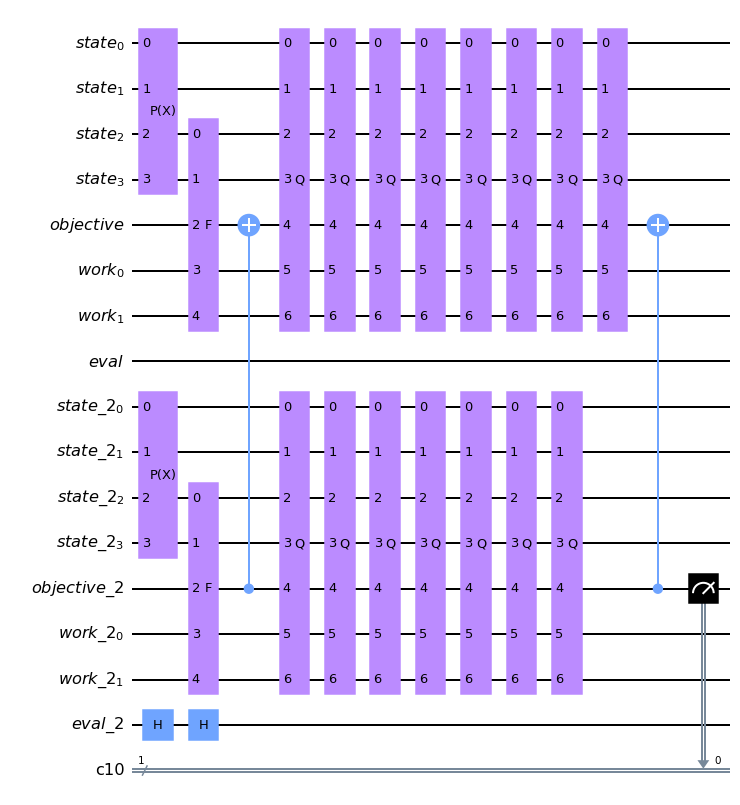

In [27]:
def get_parallelized_iqae_circuit():
    
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    qr_state2 = QuantumRegister(u.num_qubits, 'state_2')
    qr_obj2 = QuantumRegister(1, 'objective_2')
    ar2 = QuantumRegister(objective.num_ancillas, "work_2")  # additional qubits

    qr_eval = QuantumRegister(1, 'eval')
    qr_eval2 = QuantumRegister(1, 'eval_2')

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, qr_eval, qr_state2, qr_obj2, ar2, qr_eval2, name='A')

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)
    state_preparation.append(u.to_gate(), qr_state2)

    # state_preparation.cx(qr_result[0], qr_eval[0])
    state_preparation.h(qr_eval2[0])

    # linear objective function (does aggregation and comparison)
    state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
    state_preparation.append(objective_e_loss.to_gate(), qr_state2[-K:] + qr_obj2[:] + ar2[:])
    state_preparation.cx(qr_obj2[-1], qr_obj[-1])
    # state_preparation.append(problem.grover_operator.to_gate(), qr_state[:] + qr_obj[:] + ar[:])
    
    state_preparation.compose(grover_op2.power(2**(3)), qubits=qr_state[:] + qr_obj[:] + ar[:], inplace=True)
    
    state_preparation.compose(grover_op2.power(7), qubits=qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    # state_preparation.compose(grover_op2.power(2**1), qubits=qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    # state_preparation.compose(grover_op2.power(2**2), qubits=qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    # state_preparation.compose(grover_op2.power(2**3), qubits=qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    # state_preparation.compose(grover_op2.power(2**4), qubits=qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.cx(qr_obj2[-1], qr_obj[-1])
    state_preparation.h(qr_eval2[0])
    # state_preparation.append(qpe.to_gate(), qr_eval[:] + qr_state2[:] + qr_obj2[:] + ar2[:])
    # state_preparation.cx(qr_result[0], qr_result[0])
    cr = ClassicalRegister(1)
    state_preparation.add_register(cr)
    state_preparation.measure(qr_obj2[:], [0])

    return state_preparation, objective_e_loss

    
state_preparation3, objective = get_parallelized_iqae_circuit()
state_preparation3.draw("mpl")

In [17]:
from typing import Optional, Union, List, Tuple, Dict, cast
def good_state_probability(
    problem: EstimationProblem,
    counts_or_statevector: Union[Dict[str, int], np.ndarray],
    num_state_qubits: int,
):
    """Get the probability to measure '1' in the last qubit.

    Args:
        problem: The estimation problem, used to obtain the number of objective qubits and
            the ``is_good_state`` function.
        counts_or_statevector: Either a counts-dictionary (with one measured qubit only!) or
            the statevector returned from the statevector_simulator.
        num_state_qubits: The number of state qubits.

    Returns:
        If a dict is given, return (#one-counts, #one-counts/#all-counts),
        otherwise Pr(measure '1' in the last qubit).
    """
    if isinstance(counts_or_statevector, dict):
        one_counts = 0
        for state, counts in counts_or_statevector.items():
            if problem.is_good_state(state):
                one_counts += counts

        return int(one_counts), one_counts / sum(counts_or_statevector.values())
    else:
        statevector = counts_or_statevector
        num_qubits = int(np.log2(len(statevector)))  # the total number of qubits

        # sum over all amplitudes where the objective qubit is 1
        prob = 0
        for i, amplitude in enumerate(statevector):
            # consider only state qubits and revert bit order
            bitstr = bin(i)[2:].zfill(num_qubits)[-num_state_qubits:][::-1]
            objectives = [bitstr[index] for index in problem.objective_qubits]
            if problem.is_good_state(objectives):
                prob = prob + np.abs(amplitude) ** 2

        return prob

In [18]:
from scipy.stats import beta
def clopper_pearson_confint(counts: int, shots: int, alpha: float) -> Tuple[float, float]:
    """Compute the Clopper-Pearson confidence interval for `shots` i.i.d. Bernoulli trials.

    Args:
        counts: The number of positive counts.
        shots: The number of shots.
        alpha: The confidence level for the confidence interval.

    Returns:
        The Clopper-Pearson confidence interval.
    """
    lower, upper = 0, 1

    # if counts == 0, the beta quantile returns nan
    if counts != 0:
        lower = beta.ppf(alpha / 2, counts, shots - counts + 1)

    # if counts == shots, the beta quantile returns nan
    if counts != shots:
        upper = beta.ppf(1 - alpha / 2, counts + 1, shots - counts)

    return lower, upper

In [28]:
mode = 'sequentia'

qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=3000, 
                           optimization_level=optimization_level, seed_transpiler=42)
problem = EstimationProblem(state_preparation=state_preparation,
                            objective_qubits=[u.num_qubits],
                            post_processing=objective.post_processing)

iqae = IterativeAmplitudeEstimation(epsilon_target=0.01, alpha=0.1, quantum_instance=qi_ideal)
iqae_circuit = iqae.construct_circuit(problem, k=7, measurement=True)

if mode == 'sequential':
    counts = qi_ideal.execute(iqae_circuit).get_counts(iqae_circuit)
else:
    counts = qi_ideal.execute(state_preparation3).get_counts(state_preparation3)
num_qubits = iqae_circuit.num_qubits - iqae_circuit.num_ancillas
one_counts, iqae_ideal_result = good_state_probability(problem, counts, num_qubits)
max_rounds = (
            int(np.log(2 * np.pi / 8 / 0.01) / np.log(2)) + 1
        )
a_i_min, a_i_max = clopper_pearson_confint(
    one_counts, 3000, 0.1 / max_rounds
)
upper_half_circle=True

# compute theta_min_i, theta_max_i
if upper_half_circle:
    theta_min_i = np.arccos(1 - 2 * a_i_min) / 2 / np.pi
    theta_max_i = np.arccos(1 - 2 * a_i_max) / 2 / np.pi
else:
    theta_min_i = 1 - np.arccos(1 - 2 * a_i_max) / 2 / np.pi
    theta_max_i = 1 - np.arccos(1 - 2 * a_i_min) / 2 / np.pi

theta_intervals = [[0, 1 / 4]]
# compute theta_u, theta_l of this iteration
scaling = 4 * k + 2  # current K_i factor
theta_u = (int(scaling * theta_intervals[-1][1]) + theta_max_i) / scaling
theta_l = (int(scaling * theta_intervals[-1][0]) + theta_min_i) / scaling
theta_intervals.append([theta_l, theta_u])

# compute a_u_i, a_l_i
a_u = np.sin(2 * np.pi * theta_u) ** 2
a_l = np.sin(2 * np.pi * theta_l) ** 2
a_u = cast(float, a_u)
a_l = cast(float, a_l)

# get the latest confidence interval for the estimate of a
confidence_interval = tuple([a_l, a_u])

# the final estimate is the mean of the confidence interval
estimation = np.mean(confidence_interval)

print("result with no noise:", objective.post_processing(estimation), estimation)
if mode == 'sequential':
    iqae_circuit.decompose().draw("mpl")
else:
    state_preparation3.draw("mpl")

result with no noise: 108836.20727931996 0.5154965167041342


In [31]:
print(iqae.estimate(problem))

{   'alpha': 0.1,
    'circuit_results': None,
    'confidence_interval': (0.49266537236412333, 0.49433461494948744),
    'confidence_interval_processed': (2420.698632202972, 10201.00504749084),
    'epsilon_estimated': 0.0008346212926820529,
    'epsilon_estimated_processed': 3890.1532076439344,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.472489713576505, 0.5175248742924704],
                              [0.49266537236412333, 0.49433461494948744]],
    'estimation': 0.4934999936568054,
    'estimation_processed': 6310.851839847035,
    'num_oracle_queries': 39000,
    'powers': [0, 0, 13],
    'ratios': [1.0, 27.0],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.12061938982094898, 0.12778974176224556],
                           [0.12383261588580154, 0.12409830666980402]]}
